# **C318 • Projeto final**

## **Tema:**
Podemos aumentar os lucros da Starbucks ao adotar uma estratégia promocional mais seletiva?

Este projeto analisa dados e implementa um modelo de aprendizado de máquina para prever quanto alguém irá gastar com base em dados demográficos e às ofertas recebidas por eles.


### Formulação e definição do problema de ML

Enquadramento do problema de ML
```
Aprendizagem Supervisionada
```
Primeiro, estudarei os dados usando diversas técnicas de visualização e, em seguida, utilizarei:

1) Aprendizado de Máquina Supervisionado para tentar prever o valor a ser gasto no Starbucks pelo cliente, de modo que os tomadores de decisão possam identificar os usuários nos quais a oferta funciona e possam concentrar seus esforços nesses usuários.

2) Aprendizado de Máquina Supervisionado para classificar os usuários com base no tipo de gasto ("alto", "médio" ou "baixo") e fazer ofertas com base nessa classificação.

### importando bibliotecas e lendo os dados

In [31]:
import pandas as pd
import numpy as np
import math
import json

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

# pegando os arquivos json
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [38]:
print(portfolio.shape)

# transform days into hours
portfolio["duration"] = portfolio["duration"] * 24
portfolio.rename(columns={"id": "offer_id"}, inplace=True)

portfolio

(10, 6)


,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,4032,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,2880,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,2304,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,4032,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,5760,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,4032,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,5760,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,1728,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,2880,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,4032,discount,2906b810c7d4411798c6938adc9daaa5


In [39]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [40]:
print(transcript.shape)
transcript.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### criando um DataFrame para Offers e Transactions

In [41]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Aqui podemos ver que um funil é criado em cada etapa de criação.

Vamos analisar e preparar cada tipo de evento.

In [42]:
offer_received = transcript.loc[transcript['event'] == "offer received"]
offer_received

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576
257883,cb23b66c56f64b109d673d5e56574529,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576


In [43]:
offer_id = offer_received.value.str['offer id']

offer_id = pd.DataFrame(offer_id)
offer_id.rename(columns={'value': "offer_id"}, inplace=True)

offer_received = pd.concat([offer_received, offer_id], axis=1)

offer_received.drop(['value', 'event'], axis=1, inplace=True)

offer_received = offer_received.merge(portfolio, on="offer_id")

offer_received["finish_time"] = offer_received.time + offer_received.duration

In [44]:
offer_received

,person,time,offer_id,reward,channels,difficulty,duration,offer_type,finish_time
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032
...,...,...,...,...,...,...,...,...,...
76272,daad151d84664dd6a4809ab8f05af690,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,1728,informational,2304
76273,1c35792f115f4d06b138a63edf84ee4d,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,1728,informational,2304
76274,5ca2620962114246ab218fc648eb3934,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,1728,informational,2304
76275,f924927e7f844ecebf87eef93f4d2688,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,1728,informational,2304


In [45]:
offer_viewed = transcript.loc[transcript['event'] == "offer viewed"]
offer_viewed

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
...,...,...,...,...
306441,d56386cf344c4829bbf420d1895dca37,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714
306450,9b51e8797290403b90d09d864dec4b94,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714
306483,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714
306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714


In [46]:
offer_id = offer_viewed.value.str['offer id']

offer_id = pd.DataFrame(offer_id)
offer_id.rename(columns={'value': "offer_id"}, inplace=True)

offer_viewed = pd.concat([offer_viewed, offer_id], axis=1)

offer_viewed.drop(['value', 'event'], axis=1, inplace=True)

offer_viewed = offer_viewed.merge(portfolio, on="offer_id")

In [47]:
offer_viewed

,person,time,offer_id,reward,channels,difficulty,duration,offer_type
0,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,2880,bogo
1,262ad0fb526a4d53b572007da60cce24,0,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,2880,bogo
2,182e68952b474700b171e21b85c258ac,0,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,2880,bogo
3,6d28f18e91324d358d69d1e4b01f1ace,0,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,2880,bogo
4,569866874d614a6a9c30d9f1e3a23b8d,0,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,2880,bogo
...,...,...,...,...,...,...,...,...
57720,a4f3350b08934d41a80e526317842b40,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,5760,discount
57721,62e9e17c69784b6a82f6630ee3e3e82b,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,5760,discount
57722,f8ed60edd102473ab78cd33c6a044d3f,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,5760,discount
57723,345f9431137a49b3963221a55567c4a8,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,5760,discount


In [48]:
offer_completed = transcript.loc[transcript['event'] == "offer completed"]
offer_completed

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0
...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714


In [49]:
offer_id = offer_completed.value.str['offer_id']

offer_id = pd.DataFrame(offer_id)
offer_id.rename(columns={'value': "offer_id"}, inplace=True)

offer_completed = pd.concat([offer_completed, offer_id], axis=1)

offer_completed.drop(['value',"event"], axis=1, inplace=True)

offer_completed = offer_completed.merge(portfolio, on="offer_id")

offer_completed

,person,time,offer_id,reward,channels,difficulty,duration,offer_type
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,4032,discount
1,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,4032,discount
2,24115a61df25473e84a8a03f3c98de1a,0,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,4032,discount
3,2481f1fcfbcb4b288e5a03af02d95373,0,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,4032,discount
4,a45b69f1c8554ae7af83e74426ca437a,0,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,4032,discount
...,...,...,...,...,...,...,...,...
33574,5cb65af515664bb0b39cdaa089244dc7,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,5760,discount
33575,0dc85918181e4c3eb0e412d37fa8a552,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,5760,discount
33576,f74033a8c6834303bd1b3ef0c98d11d8,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,5760,discount
33577,f3e801caeafe4899b3b989b586e74ac7,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,5760,discount


In [50]:
transaction = transcript.loc[transcript['event'] == "transaction"]
transaction

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [51]:
amount = transaction.value.str['amount']

amount = pd.DataFrame(amount)
amount.rename(columns={'value': "amount"}, inplace=True)

transaction = pd.concat([transaction, amount], axis=1)

transaction.drop(['value', 'event'], axis=1, inplace=True)

transaction

,person,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97
...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53
306531,a00058cf10334a308c68e7631c529907,714,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53


In [52]:
offer_viewed.rename(columns={"time": "view_time"}, inplace=True)
offer_completed.rename(columns={"time": "comp_time"}, inplace=True)

### criando um dataset completo pra offer

In [53]:
offer_received.shape

(76277, 9)

pra cada offer recebida, ver se ela foi visualizada (viewed)

In [54]:
viewed_group = offer_viewed.groupby("person")

def was_viewed(row):
    try:
        user_view = viewed_group.get_group(row["person"])
    except:
        return False

    user_view = user_view.loc[(user_view["offer_id"] == row["offer_id"]) &
                              (user_view["view_time"] >= row["time"])   &
                              (user_view["view_time"] <= row["finish_time"])]


    return bool(user_view.shape[0])

offers = offer_received.copy()

offers["viewed"] = offers.apply(lambda row: was_viewed(row), axis=1)

offers

,person,time,offer_id,reward,channels,difficulty,duration,offer_type,finish_time,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032,True
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032,True
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032,True
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032,True
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032,False
...,...,...,...,...,...,...,...,...,...,...
76272,daad151d84664dd6a4809ab8f05af690,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,1728,informational,2304,True
76273,1c35792f115f4d06b138a63edf84ee4d,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,1728,informational,2304,True
76274,5ca2620962114246ab218fc648eb3934,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,1728,informational,2304,False
76275,f924927e7f844ecebf87eef93f4d2688,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,1728,informational,2304,True


pra cada offer, ver se ela foi completada (completed)

In [55]:
completed_group = offer_completed.groupby("person")

def was_completed(row):
    try:
        user_comp = completed_group.get_group(row["person"])
    except:
        return False

    user_comp = user_comp.loc[(user_comp["offer_id"] == row["offer_id"]) &
                              (user_comp["comp_time"] >= row["time"])   &
                              (user_comp["comp_time"] <= row["finish_time"])]


    return bool(user_comp.shape[0])

offers["completed"] = offers.apply(lambda row: was_completed(row), axis=1)

offers

,person,time,offer_id,reward,channels,difficulty,duration,offer_type,finish_time,viewed,completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032,True,True
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032,True,False
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032,True,True
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032,True,True
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,4032,bogo,4032,False,False
...,...,...,...,...,...,...,...,...,...,...,...
76272,daad151d84664dd6a4809ab8f05af690,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,1728,informational,2304,True,False
76273,1c35792f115f4d06b138a63edf84ee4d,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,1728,informational,2304,True,False
76274,5ca2620962114246ab218fc648eb3934,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,1728,informational,2304,False,False
76275,f924927e7f844ecebf87eef93f4d2688,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,1728,informational,2304,True,False


transformando o portfolio id em uma sequencia pra ver melhor

In [56]:
portfolio['offer_id'] = portfolio['offer_id'].rank(method='dense', ascending=False).astype(int)

In [57]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,4032,bogo,3
1,10,"[web, email, mobile, social]",10,2880,bogo,6
2,0,"[web, email, mobile]",0,2304,informational,7
3,5,"[web, email, mobile]",5,4032,bogo,4
4,5,"[web, email]",20,5760,discount,10
5,3,"[web, email, mobile, social]",7,4032,discount,9
6,2,"[web, email, mobile, social]",10,5760,discount,1
7,0,"[email, mobile, social]",0,1728,informational,5
8,5,"[web, email, mobile, social]",5,2880,bogo,2
9,2,"[web, email, mobile]",10,4032,discount,8


In [58]:
offers['offer_id'] = offers['offer_id'].rank(method='dense', ascending=False).astype(int)
offers

,person,time,offer_id,reward,channels,difficulty,duration,offer_type,finish_time,viewed,completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,4,5,"[web, email, mobile]",5,4032,bogo,4032,True,True
1,ebe7ef46ea6f4963a7dd49f501b26779,0,4,5,"[web, email, mobile]",5,4032,bogo,4032,True,False
2,f082d80f0aac47a99173ba8ef8fc1909,0,4,5,"[web, email, mobile]",5,4032,bogo,4032,True,True
3,c0d210398dee4a0895b24444a5fcd1d2,0,4,5,"[web, email, mobile]",5,4032,bogo,4032,True,True
4,57dd18ec5ddc46828afb81ec5977bef2,0,4,5,"[web, email, mobile]",5,4032,bogo,4032,False,False
...,...,...,...,...,...,...,...,...,...,...,...
76272,daad151d84664dd6a4809ab8f05af690,576,5,0,"[email, mobile, social]",0,1728,informational,2304,True,False
76273,1c35792f115f4d06b138a63edf84ee4d,576,5,0,"[email, mobile, social]",0,1728,informational,2304,True,False
76274,5ca2620962114246ab218fc648eb3934,576,5,0,"[email, mobile, social]",0,1728,informational,2304,False,False
76275,f924927e7f844ecebf87eef93f4d2688,576,5,0,"[email, mobile, social]",0,1728,informational,2304,True,False


In [59]:
offers["difficulty"] = offers["reward"] / offers["difficulty"]
offers["difficulty"].fillna(0)
offers

,person,time,offer_id,reward,channels,difficulty,duration,offer_type,finish_time,viewed,completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,4,5,"[web, email, mobile]",1.0,4032,bogo,4032,True,True
1,ebe7ef46ea6f4963a7dd49f501b26779,0,4,5,"[web, email, mobile]",1.0,4032,bogo,4032,True,False
2,f082d80f0aac47a99173ba8ef8fc1909,0,4,5,"[web, email, mobile]",1.0,4032,bogo,4032,True,True
3,c0d210398dee4a0895b24444a5fcd1d2,0,4,5,"[web, email, mobile]",1.0,4032,bogo,4032,True,True
4,57dd18ec5ddc46828afb81ec5977bef2,0,4,5,"[web, email, mobile]",1.0,4032,bogo,4032,False,False
...,...,...,...,...,...,...,...,...,...,...,...
76272,daad151d84664dd6a4809ab8f05af690,576,5,0,"[email, mobile, social]",NaN,1728,informational,2304,True,False
76273,1c35792f115f4d06b138a63edf84ee4d,576,5,0,"[email, mobile, social]",NaN,1728,informational,2304,True,False
76274,5ca2620962114246ab218fc648eb3934,576,5,0,"[email, mobile, social]",NaN,1728,informational,2304,False,False
76275,f924927e7f844ecebf87eef93f4d2688,576,5,0,"[email, mobile, social]",NaN,1728,informational,2304,True,False


### informacoes para entender os dados

In [60]:
print(f"Offers received {offer_received.shape[0]}")
print(f"Offers viewed {offer_viewed.shape[0]}")
print(f"Offers Completed {offer_completed.shape[0]}")

Offers received 76277
Offers viewed 57725
Offers Completed 33579


In [61]:
print(f"Offers received {offers.shape[0]}")
print(f"Offers viewed {offers.viewed.sum()}")
print(f"Offers Completed {offers.completed.sum()}")

Offers received 76277
Offers viewed 58941
Offers Completed 34925


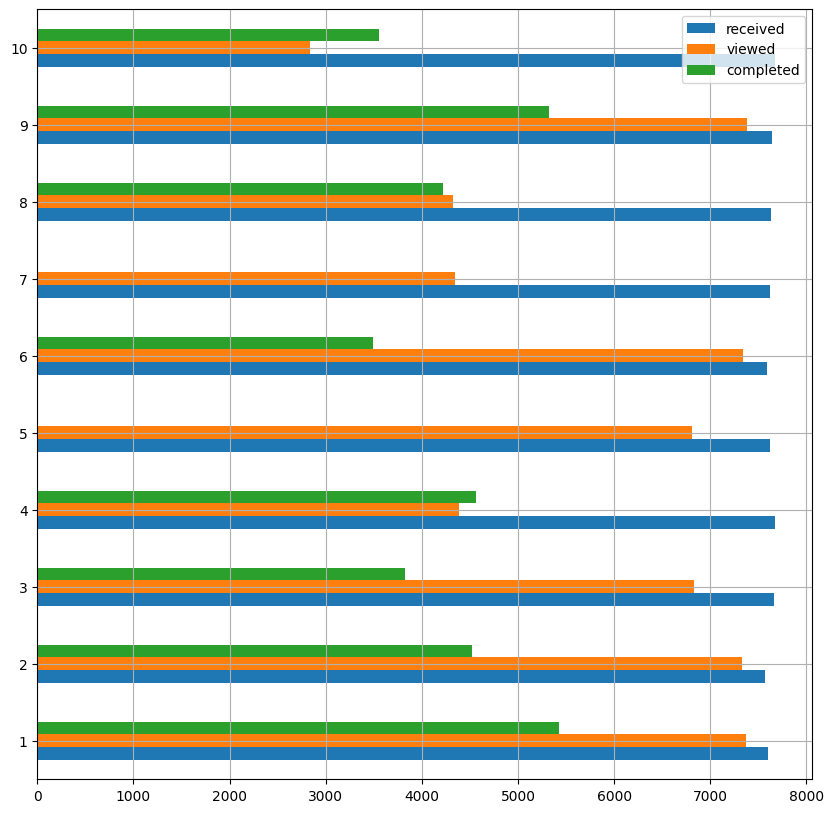

In [62]:
offers_group = offers.groupby("offer_id")


plt.rcParams["figure.figsize"] = (10,10)
df = pd.DataFrame({'received': offers_group.person.count().values,
                   'viewed': offers_group.viewed.sum().values,
                   'completed': offers_group.completed.sum().values},
                  index=offers_group.groups.keys())

ax = df.plot.barh(rot=0)

plt.grid()
plt.show()

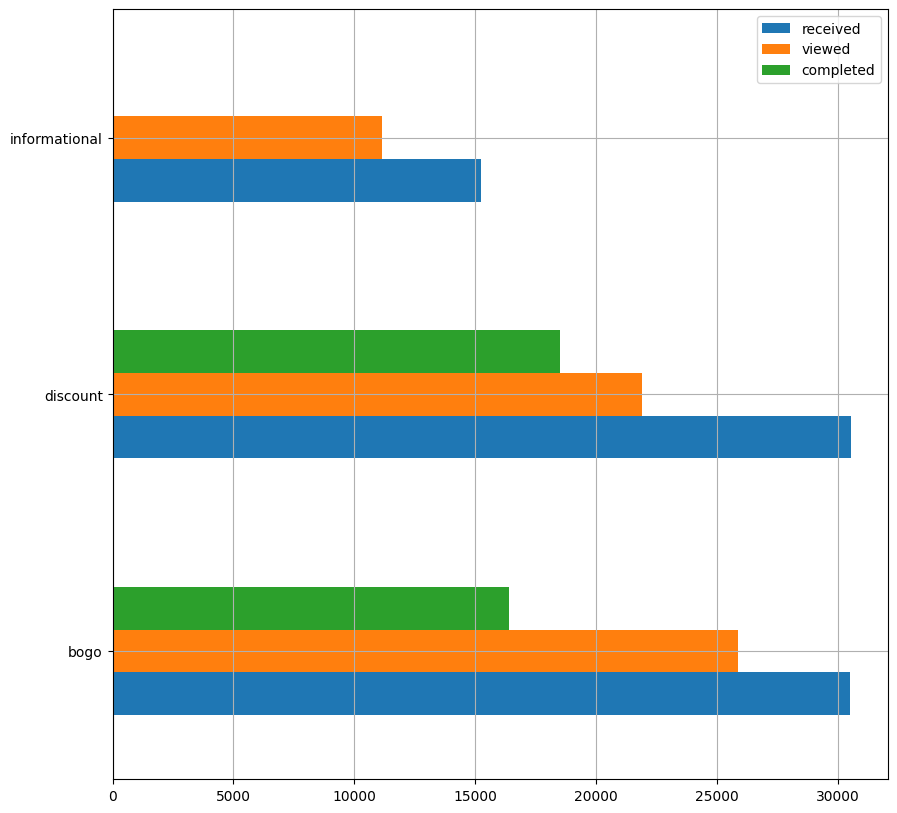

In [63]:
offers_group = offers.groupby("offer_type")

df = pd.DataFrame({'received': offers_group.person.count().values,
                   'viewed': offers_group.viewed.sum().values,
                   'completed': offers_group.completed.sum().values},
                  index=offers_group.groups.keys())

ax = df.plot.barh(rot=0)

plt.grid()
plt.show()

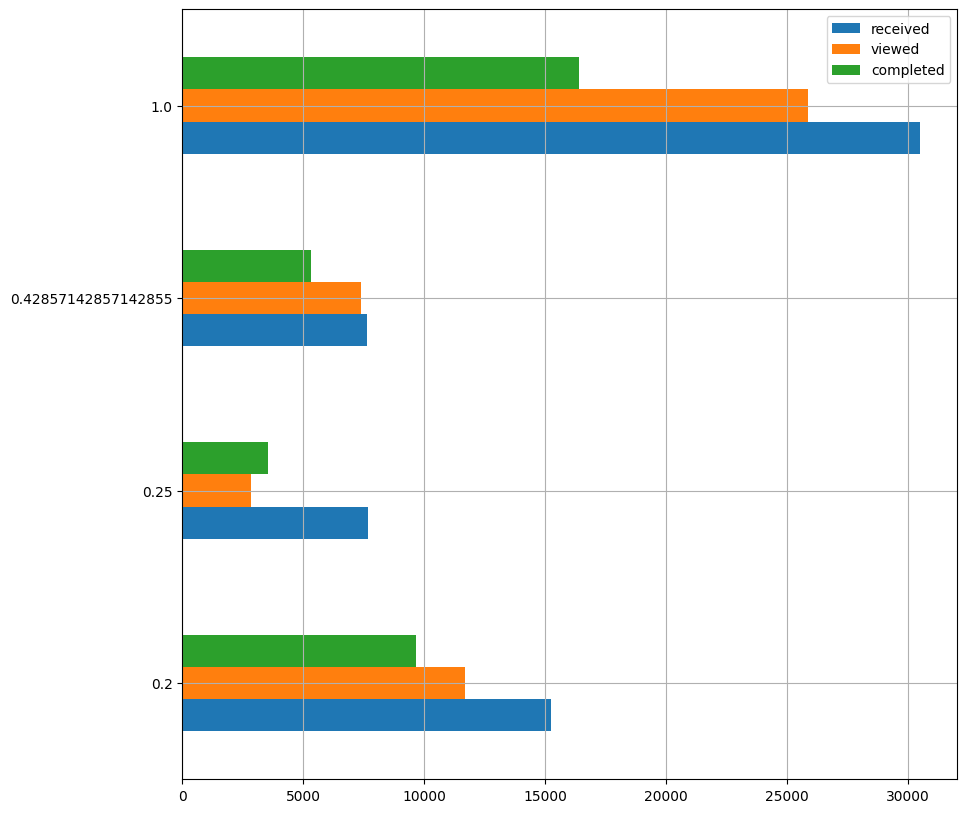

In [64]:
offers_group = offers.groupby("difficulty")

df = pd.DataFrame({'received': offers_group.person.count().values,
                   'viewed': offers_group.viewed.sum().values,
                   'completed': offers_group.completed.sum().values},
                  index=offers_group.groups.keys())

ax = df.plot.barh(rot=0)

plt.grid()
plt.show()

### sobre o perfil e transações:

somando quanto cada cliente gastou

In [65]:
amount_sum = pd.pivot_table(transaction, values='amount', index=['person'],
                         aggfunc=np.sum)
amount_count = pd.pivot_table(transaction, values='amount', index=['person'],
                         aggfunc=np.count_nonzero)
amount_count.columns = ['count']
df_count_sum = pd.concat([amount_sum, amount_count], axis=1)
df_count_sum = df_count_sum.reset_index()
df_count_sum.columns = ['id', 'amount', 'count']

df_count_sum

,id,amount,count
0,0009655768c64bdeb2e877511632db8f,127.60,8
1,00116118485d4dfda04fdbaba9a87b5c,4.09,3
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,5
3,0020c2b971eb4e9188eac86d93036a77,196.86,8
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12
...,...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,580.98,11
16574,fff7576017104bcc8677a8d63322b5e1,29.94,6
16575,fff8957ea8b240a6b5e634b6ee8eafcf,12.15,5
16576,fffad4f4828548d1b5583907f2e9906b,88.83,12


In [66]:
complete_profile  = pd.merge(profile, df_count_sum, on="id")
complete_profile

,gender,age,id,became_member_on,income,amount,count
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,20.40,9
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,14.30,6
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,4.65,3
...,...,...,...,...,...,...,...
16573,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,20.03,7
16574,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,25.97,7
16575,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,39.74,8
16576,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,189.67,14


In [67]:
complete_profile = complete_profile[complete_profile["age"] < 100].reset_index()

In [68]:
complete_profile.income.describe()

count     14475.000000
mean      65206.977547
std       21595.851767
min       30000.000000
25%       49000.000000
50%       63000.000000
75%       79000.000000
max      120000.000000
Name: income, dtype: float64

In [69]:
offer_received_count = pd.pivot_table(offer_received, values="offer_id", index=['person'], aggfunc=np.count_nonzero)

offer_received_count = offer_received_count.reset_index()
offer_received_count.columns = ['id','offers_received']

offer_received_count

,id,offers_received
0,0009655768c64bdeb2e877511632db8f,5
1,00116118485d4dfda04fdbaba9a87b5c,2
2,0011e0d4e6b944f998e987f904e8c1e5,5
3,0020c2b971eb4e9188eac86d93036a77,5
4,0020ccbbb6d84e358d3414a3ff76cffd,4
...,...,...
16989,fff3ba4757bd42088c044ca26d73817a,6
16990,fff7576017104bcc8677a8d63322b5e1,5
16991,fff8957ea8b240a6b5e634b6ee8eafcf,3
16992,fffad4f4828548d1b5583907f2e9906b,4


In [70]:
complete_profile  = pd.merge(complete_profile, offer_received_count, on="id")
complete_profile

,index,gender,age,id,became_member_on,income,amount,count,offers_received
0,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3,2
1,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7,4
2,5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,57.73,3,4
3,7,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,36.43,3,6
4,11,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,15.62,4,3
...,...,...,...,...,...,...,...,...,...
14465,16573,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,20.03,7,3
14466,16574,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,25.97,7,3
14467,16575,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,39.74,8,3
14468,16576,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,189.67,14,3


In [71]:
offer_mean_reward= pd.pivot_table(offer_completed, values='reward', index=['person'],
                                    aggfunc=np.mean)

offer_count = pd.pivot_table(offer_completed, values='offer_id', index=['person'],
                                    aggfunc=np.count_nonzero)

com_offer_completed = pd.concat([offer_mean_reward, offer_count], axis=1)
com_offer_completed = com_offer_completed.reset_index()
com_offer_completed.columns = ['id','avg_reward','offers_done']

com_offer_completed


,id,avg_reward,offers_done
0,0009655768c64bdeb2e877511632db8f,3.000000,3
1,0011e0d4e6b944f998e987f904e8c1e5,4.333333,3
2,0020c2b971eb4e9188eac86d93036a77,4.666667,3
3,0020ccbbb6d84e358d3414a3ff76cffd,4.333333,3
4,003d66b6608740288d6cc97a6903f4f0,3.000000,3
...,...,...,...
12769,fff29fb549084123bd046dbc5ceb4faa,7.833333,6
12770,fff3ba4757bd42088c044ca26d73817a,3.000000,3
12771,fff7576017104bcc8677a8d63322b5e1,3.000000,3
12772,fffad4f4828548d1b5583907f2e9906b,5.000000,3


In [72]:
complete_profile

,index,gender,age,id,became_member_on,income,amount,count,offers_received
0,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3,2
1,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7,4
2,5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,57.73,3,4
3,7,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,36.43,3,6
4,11,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,15.62,4,3
...,...,...,...,...,...,...,...,...,...
14465,16573,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,20.03,7,3
14466,16574,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,25.97,7,3
14467,16575,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,39.74,8,3
14468,16576,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,189.67,14,3


In [73]:
complete_profile = pd.merge(complete_profile, com_offer_completed, on="id")
complete_profile['purchase_rate'] = complete_profile['offers_done']/complete_profile['offers_received']

complete_profile


,index,gender,age,id,became_member_on,income,amount,count,offers_received,avg_reward,offers_done,purchase_rate
0,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3,2,5.000000,1,0.500000
1,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7,4,6.666667,3,0.750000
2,5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,57.73,3,4,3.500000,2,0.500000
3,7,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,36.43,3,6,3.800000,5,0.833333
4,11,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,15.62,4,3,2.000000,1,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
11964,16568,F,70,79edb810789c447e8d212a324b44cc16,20160310,39000.0,143.75,15,5,3.750000,4,0.800000
11965,16571,M,60,cb23b66c56f64b109d673d5e56574529,20180505,113000.0,115.59,5,3,2.000000,1,0.333333
11966,16574,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,25.97,7,3,5.000000,1,0.333333
11967,16576,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,189.67,14,3,8.333333,3,1.000000


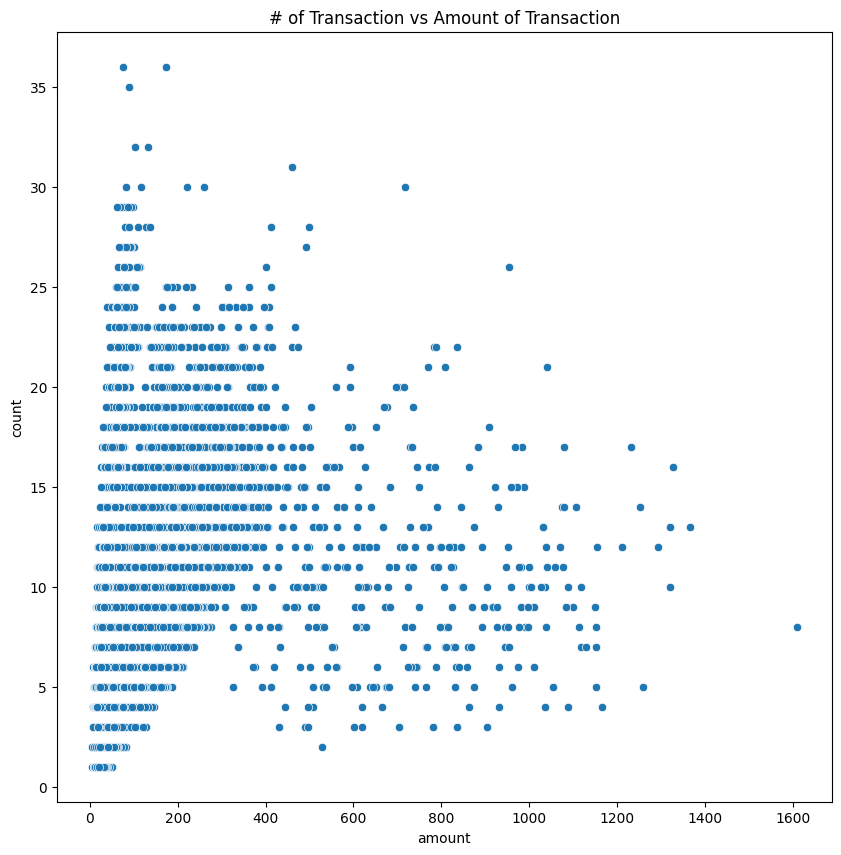

In [74]:
fig, ax = plt.subplots()

sn.scatterplot(x=complete_profile['amount'],
               y=complete_profile['count']).set_title('# of Transaction vs Amount of Transaction');

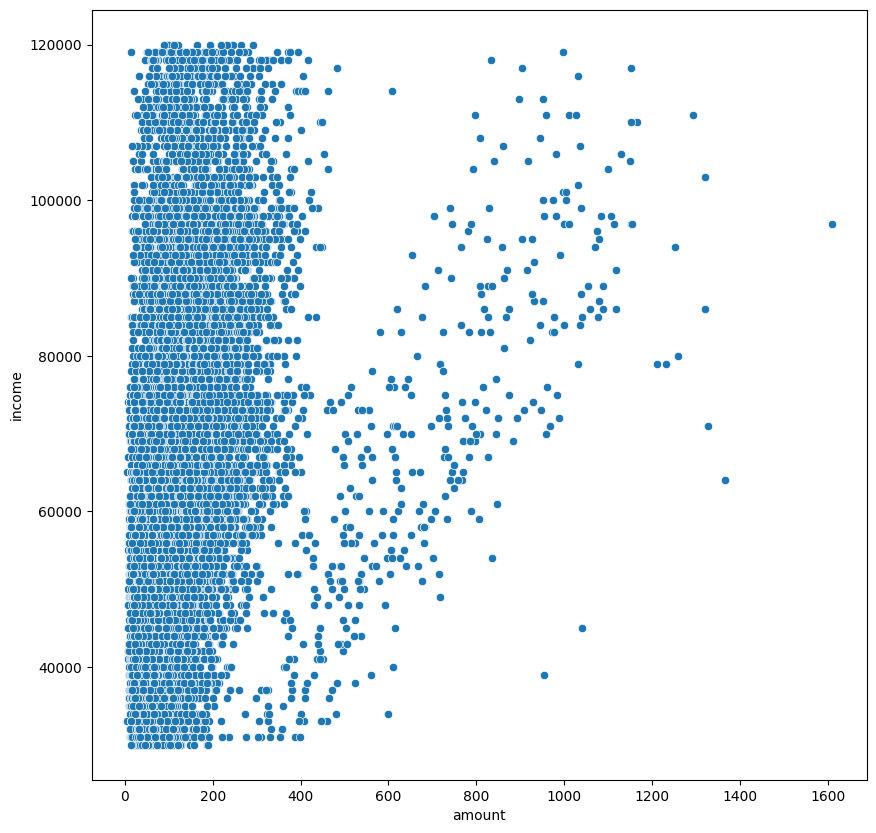

In [75]:
fig, ax = plt.subplots()

sn.scatterplot(x=complete_profile['amount'],
               y=complete_profile['income']);

In [76]:
complete_profile = complete_profile[complete_profile["age"] < 100].reset_index()

del complete_profile['index']
complete_profile["age"].describe()

count    11969.000000
mean        55.172613
std         16.966390
min         18.000000
25%         44.000000
50%         56.000000
75%         67.000000
max         99.000000
Name: age, dtype: float64

### criando valores categoricos para o nosso modelo

In [77]:
def age_label_func(row):
    if row['age'] <= 30: return "young-adult"
    elif row['age'] <= 60: return "adult"
    else: return "elderly"

complete_profile['age_label'] = complete_profile.apply(lambda row: age_label_func(row), axis=1)

complete_profile

,level_0,gender,age,id,became_member_on,income,amount,count,offers_received,avg_reward,offers_done,purchase_rate,age_label
0,0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3,2,5.000000,1,0.500000,adult
1,1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7,4,6.666667,3,0.750000,elderly
2,2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,57.73,3,4,3.500000,2,0.500000,elderly
3,3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,36.43,3,6,3.800000,5,0.833333,elderly
4,4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,15.62,4,3,2.000000,1,0.333333,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,11964,F,70,79edb810789c447e8d212a324b44cc16,20160310,39000.0,143.75,15,5,3.750000,4,0.800000,elderly
11965,11965,M,60,cb23b66c56f64b109d673d5e56574529,20180505,113000.0,115.59,5,3,2.000000,1,0.333333,adult
11966,11966,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,25.97,7,3,5.000000,1,0.333333,elderly
11967,11967,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,189.67,14,3,8.333333,3,1.000000,elderly


In [78]:
def income_label_func(row):
    if row['income'] <= 60000: return "avarage"
    elif row['income'] <= 90000: return "above-average"
    else: return "high"

complete_profile['income_label'] = complete_profile.apply(lambda row: income_label_func(row), axis=1)

complete_profile

,level_0,gender,age,id,became_member_on,income,amount,count,offers_received,avg_reward,offers_done,purchase_rate,age_label,income_label
0,0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3,2,5.000000,1,0.500000,adult,high
1,1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7,4,6.666667,3,0.750000,elderly,high
2,2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,57.73,3,4,3.500000,2,0.500000,elderly,above-average
3,3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,36.43,3,6,3.800000,5,0.833333,elderly,avarage
4,4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,15.62,4,3,2.000000,1,0.333333,adult,avarage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,11964,F,70,79edb810789c447e8d212a324b44cc16,20160310,39000.0,143.75,15,5,3.750000,4,0.800000,elderly,avarage
11965,11965,M,60,cb23b66c56f64b109d673d5e56574529,20180505,113000.0,115.59,5,3,2.000000,1,0.333333,adult,high
11966,11966,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,25.97,7,3,5.000000,1,0.333333,elderly,above-average
11967,11967,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,189.67,14,3,8.333333,3,1.000000,elderly,avarage


In [79]:
complete_profile["became_member_on"] = complete_profile["became_member_on"].astype(str).str[:4]
complete_profile

,level_0,gender,age,id,became_member_on,income,amount,count,offers_received,avg_reward,offers_done,purchase_rate,age_label,income_label
0,0,F,55,0610b486422d4921ae7d2bf64640c50b,2017,112000.0,77.01,3,2,5.000000,1,0.500000,adult,high
1,1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0,159.27,7,4,6.666667,3,0.750000,elderly,high
2,2,M,68,e2127556f4f64592b11af22de27a7932,2018,70000.0,57.73,3,4,3.500000,2,0.500000,elderly,above-average
3,3,M,65,389bc3fa690240e798340f5a15918d5c,2018,53000.0,36.43,3,6,3.800000,5,0.833333,elderly,avarage
4,4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017,51000.0,15.62,4,3,2.000000,1,0.333333,adult,avarage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,11964,F,70,79edb810789c447e8d212a324b44cc16,2016,39000.0,143.75,15,5,3.750000,4,0.800000,elderly,avarage
11965,11965,M,60,cb23b66c56f64b109d673d5e56574529,2018,113000.0,115.59,5,3,2.000000,1,0.333333,adult,high
11966,11966,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018,72000.0,25.97,7,3,5.000000,1,0.333333,elderly,above-average
11967,11967,F,83,9dc1421481194dcd9400aec7c9ae6366,2016,50000.0,189.67,14,3,8.333333,3,1.000000,elderly,avarage


### merge profile e offer datasets

In [80]:
complete_profile

,level_0,gender,age,id,became_member_on,income,amount,count,offers_received,avg_reward,offers_done,purchase_rate,age_label,income_label
0,0,F,55,0610b486422d4921ae7d2bf64640c50b,2017,112000.0,77.01,3,2,5.000000,1,0.500000,adult,high
1,1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0,159.27,7,4,6.666667,3,0.750000,elderly,high
2,2,M,68,e2127556f4f64592b11af22de27a7932,2018,70000.0,57.73,3,4,3.500000,2,0.500000,elderly,above-average
3,3,M,65,389bc3fa690240e798340f5a15918d5c,2018,53000.0,36.43,3,6,3.800000,5,0.833333,elderly,avarage
4,4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017,51000.0,15.62,4,3,2.000000,1,0.333333,adult,avarage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,11964,F,70,79edb810789c447e8d212a324b44cc16,2016,39000.0,143.75,15,5,3.750000,4,0.800000,elderly,avarage
11965,11965,M,60,cb23b66c56f64b109d673d5e56574529,2018,113000.0,115.59,5,3,2.000000,1,0.333333,adult,high
11966,11966,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018,72000.0,25.97,7,3,5.000000,1,0.333333,elderly,above-average
11967,11967,F,83,9dc1421481194dcd9400aec7c9ae6366,2016,50000.0,189.67,14,3,8.333333,3,1.000000,elderly,avarage


In [81]:
complete_df = offers.copy()

complete_df.rename(columns={"person": "id"}, inplace=True)

complete_df = complete_df.merge(complete_profile, on="id", how="left")
complete_df

,id,time,offer_id,reward,channels,difficulty,duration,offer_type,finish_time,viewed,...,became_member_on,income,amount,count,offers_received,avg_reward,offers_done,purchase_rate,age_label,income_label
0,78afa995795e4d85b5d9ceeca43f5fef,0,4,5,"[web, email, mobile]",1.0,4032,bogo,4032,True,...,2017,100000.0,159.27,7.0,4.0,6.666667,3.0,0.750000,elderly,high
1,ebe7ef46ea6f4963a7dd49f501b26779,0,4,5,"[web, email, mobile]",1.0,4032,bogo,4032,True,...,2015,41000.0,52.08,13.0,6.0,2.000000,2.0,0.333333,adult,avarage
2,f082d80f0aac47a99173ba8ef8fc1909,0,4,5,"[web, email, mobile]",1.0,4032,bogo,4032,True,...,2016,33000.0,40.94,14.0,6.0,5.000000,1.0,0.166667,adult,avarage
3,c0d210398dee4a0895b24444a5fcd1d2,0,4,5,"[web, email, mobile]",1.0,4032,bogo,4032,True,...,2018,33000.0,61.25,8.0,5.0,6.000000,3.0,0.600000,adult,avarage
4,57dd18ec5ddc46828afb81ec5977bef2,0,4,5,"[web, email, mobile]",1.0,4032,bogo,4032,False,...,2017,80000.0,249.40,9.0,6.0,5.666667,3.0,0.500000,adult,above-average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,daad151d84664dd6a4809ab8f05af690,576,5,0,"[email, mobile, social]",NaN,1728,informational,2304,True,...,2016,86000.0,305.57,15.0,6.0,5.400000,5.0,0.833333,adult,above-average
76273,1c35792f115f4d06b138a63edf84ee4d,576,5,0,"[email, mobile, social]",NaN,1728,informational,2304,True,...,2017,71000.0,248.26,14.0,6.0,7.500000,2.0,0.333333,elderly,above-average
76274,5ca2620962114246ab218fc648eb3934,576,5,0,"[email, mobile, social]",NaN,1728,informational,2304,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76275,f924927e7f844ecebf87eef93f4d2688,576,5,0,"[email, mobile, social]",NaN,1728,informational,2304,True,...,2016,93000.0,266.11,11.0,6.0,5.000000,4.0,0.666667,adult,high


### ofertas mais comuns para cada grupo de idades:

excluindo pessoas com mais de 100 anos

<Axes: >

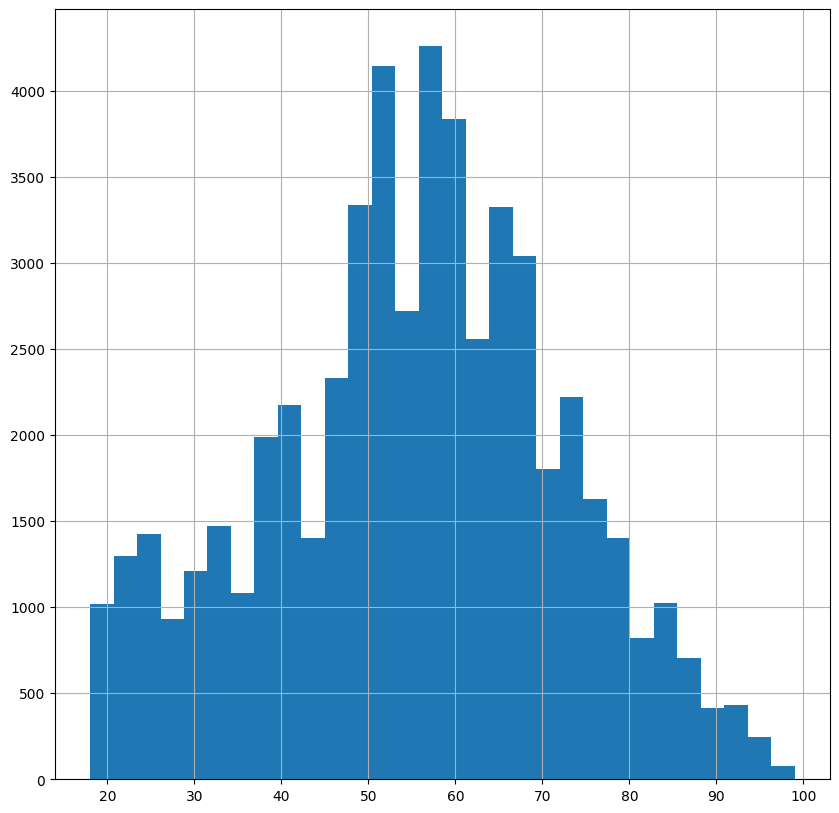

In [82]:
complete_df['age'].hist(bins=30)

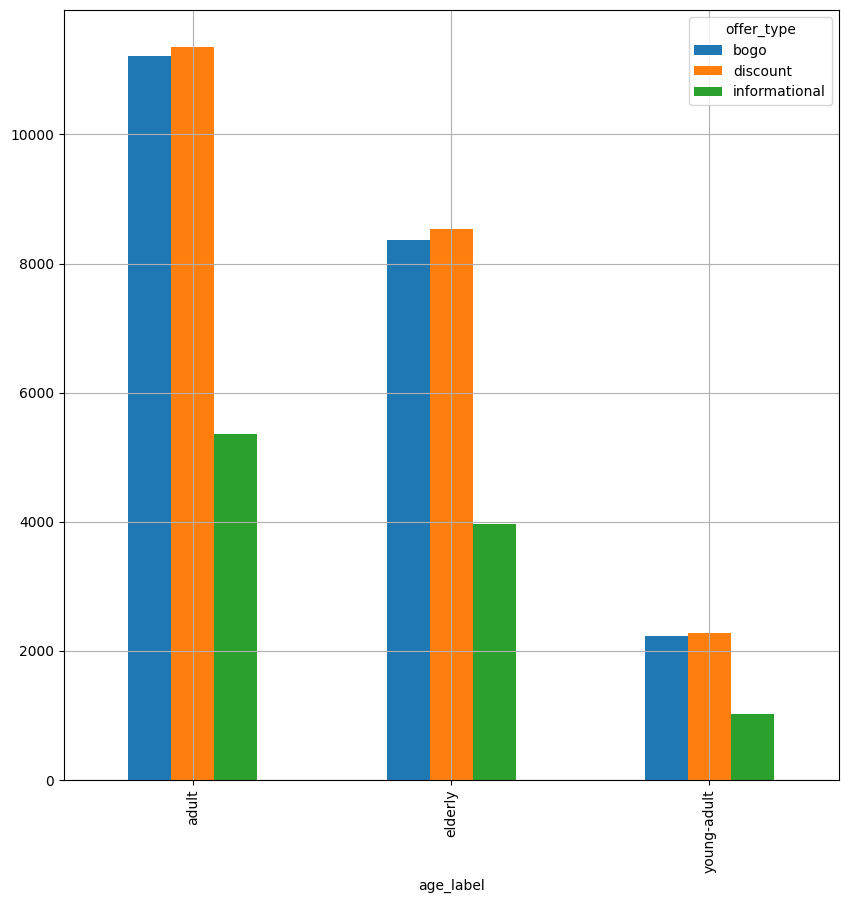

In [83]:
complete_df.groupby("offer_type").age_label.value_counts().unstack(0).plot.bar()

plt.grid()
plt.show()

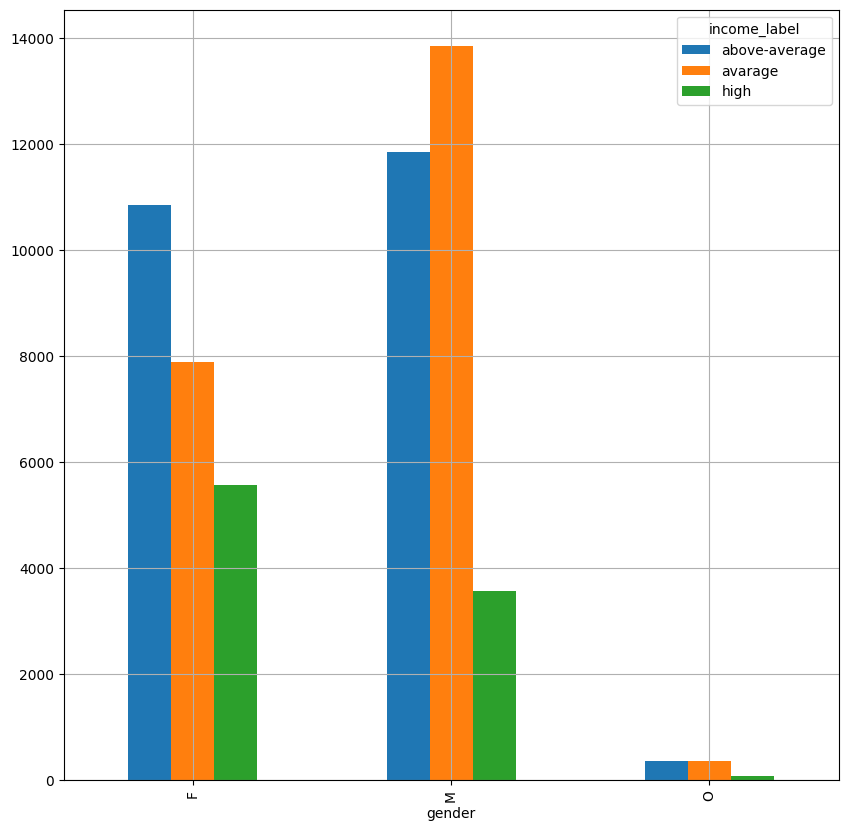

In [84]:
complete_df.groupby("income_label").gender.value_counts().unstack(0).plot.bar()

plt.grid()
plt.show()

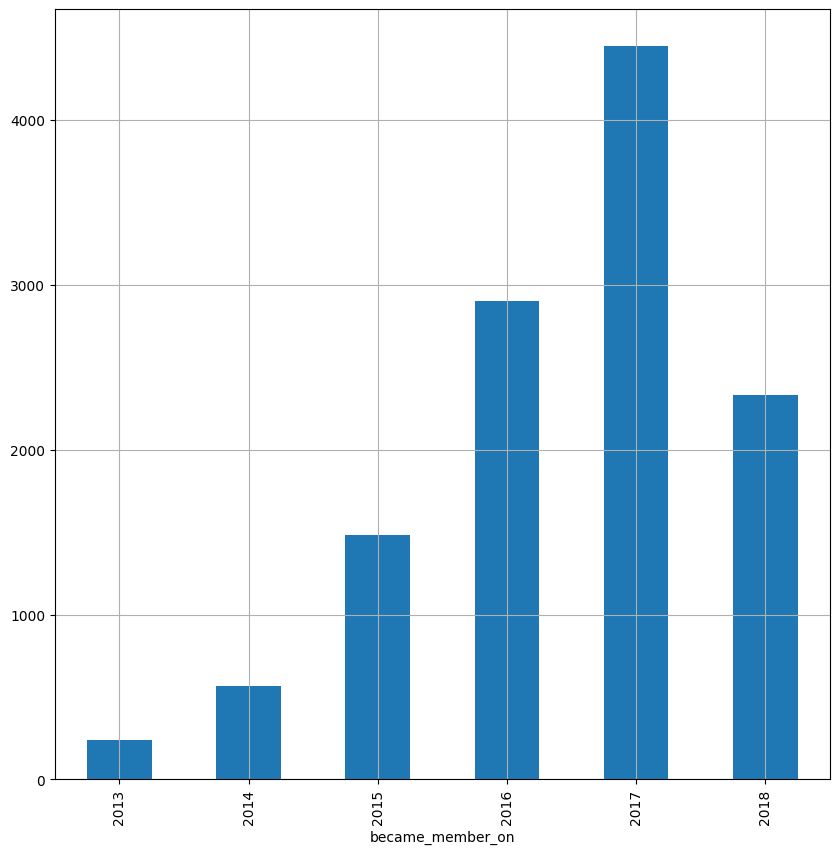

In [85]:
complete_profile.groupby("became_member_on").id.count().plot.bar()

plt.grid()
plt.show()

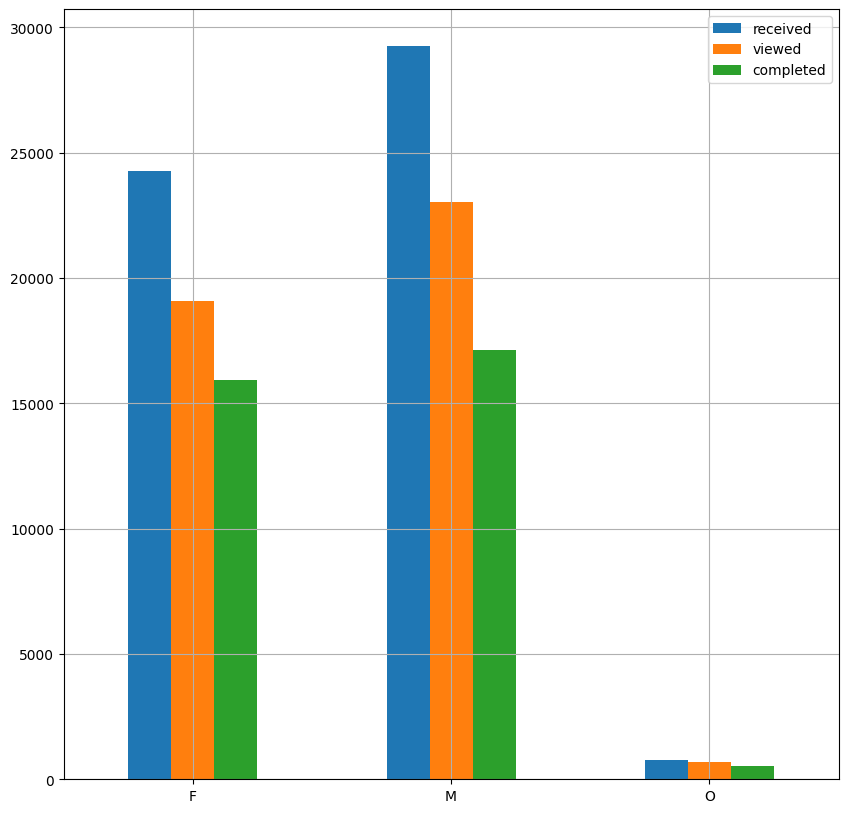

In [86]:
offers_group = complete_df.groupby("gender")


df = pd.DataFrame({'received': offers_group.id.count().values,
                   'viewed': offers_group.viewed.sum().values,
                   'completed': offers_group.completed.sum().values},
                  index=offers_group.groups.keys())

ax = df.plot.bar(rot=0)

plt.grid()
plt.show()

### criando Labels para as predicoes:

In [87]:
complete_profile.columns

Index(['level_0', 'gender', 'age', 'id', 'became_member_on', 'income',
       'amount', 'count', 'offers_received', 'avg_reward', 'offers_done',
       'purchase_rate', 'age_label', 'income_label'],
      dtype='object')

In [88]:
complete_profile['amount'].describe()

count    11969.000000
mean       139.611514
std        133.518325
min          5.280000
25%         57.340000
50%        112.160000
75%        179.640000
max       1608.690000
Name: amount, dtype: float64

In [89]:
def get_spent_label(row):
    spent_value = row['amount'] / row['income']


    if spent_value <= 0.000799: return "very low"
    elif spent_value <= 0.001570: return "low"
    elif spent_value <= 0.002607: return "medium"
    elif spent_value <= 0.005: return "high"
    else: return "very high"

complete_profile['spent_label'] = complete_profile.apply(lambda row: get_spent_label(row), axis=1)


complete_profile['spent_label']

0        very low
1          medium
2             low
3        very low
4        very low
           ...   
11964        high
11965         low
11966    very low
11967        high
11968      medium
Name: spent_label, Length: 11969, dtype: object

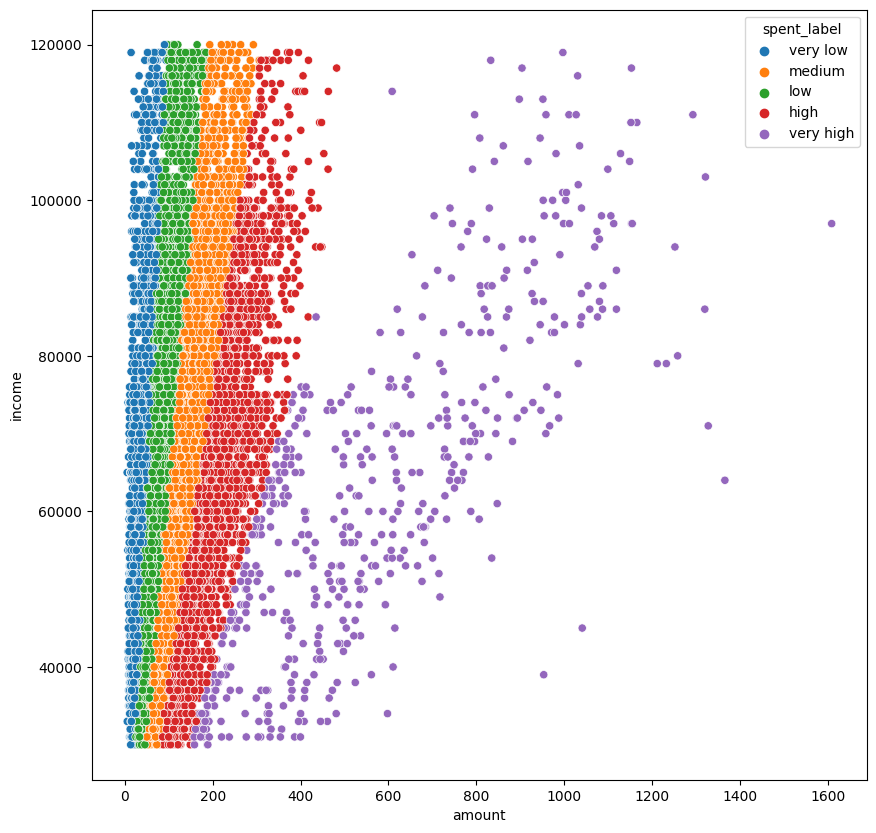

In [91]:
fig, ax = plt.subplots()
sn.scatterplot(x=complete_profile['amount'],y= complete_profile['income'], hue=complete_profile['spent_label']);

<ipython-input-92-d6c4366e8363>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(complete_profile.corr(), annot = True, ax=ax)


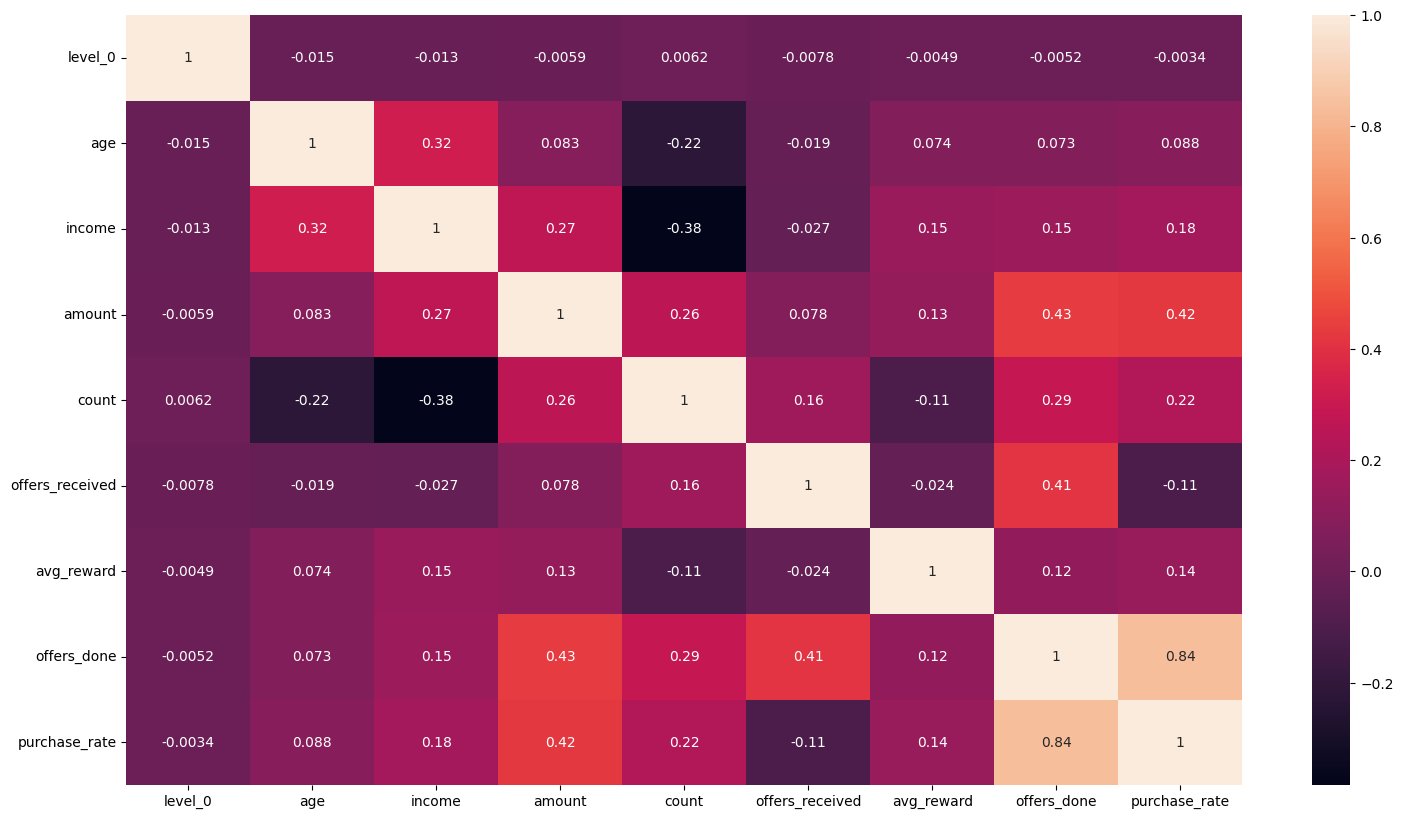

In [92]:
fig, ax = plt.subplots(figsize=(18,10))
sn.heatmap(complete_profile.corr(), annot = True, ax=ax)
plt.show()

### usando random forest para predicoes de gastos

In [93]:
dummie_df = complete_profile.copy()

In [94]:
dummie_df.columns

Index(['level_0', 'gender', 'age', 'id', 'became_member_on', 'income',
       'amount', 'count', 'offers_received', 'avg_reward', 'offers_done',
       'purchase_rate', 'age_label', 'income_label', 'spent_label'],
      dtype='object')

In [95]:
dummie_df = pd.concat([dummie_df, pd.get_dummies(dummie_df["gender"])], axis=1)
del dummie_df['gender']

dummie_df = pd.concat([dummie_df, pd.get_dummies(dummie_df["age_label"])], axis=1)
del dummie_df['age_label']

dummie_df = pd.concat([dummie_df, pd.get_dummies(dummie_df["income_label"])], axis=1)
del dummie_df['income_label']

dummie_df.columns

Index(['level_0', 'age', 'id', 'became_member_on', 'income', 'amount', 'count',
       'offers_received', 'avg_reward', 'offers_done', 'purchase_rate',
       'spent_label', 'F', 'M', 'O', 'adult', 'elderly', 'young-adult',
       'above-average', 'avarage', 'high'],
      dtype='object')

In [96]:
X = dummie_df[['F', 'M', 'O', 'adult', 'elderly', 'young-adult', 'above-average', 'avarage',
       'high', "became_member_on", 'offers_received', 'offers_done', 'income', 'amount']]

X

,F,M,O,adult,elderly,young-adult,above-average,avarage,high,became_member_on,offers_received,offers_done,income,amount
0,1,0,0,1,0,0,0,0,1,2017,2,1,112000.0,77.01
1,1,0,0,0,1,0,0,0,1,2017,4,3,100000.0,159.27
2,0,1,0,0,1,0,1,0,0,2018,4,2,70000.0,57.73
3,0,1,0,0,1,0,0,1,0,2018,6,5,53000.0,36.43
4,0,1,0,1,0,0,0,1,0,2017,3,1,51000.0,15.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,1,0,0,0,1,0,0,1,0,2016,5,4,39000.0,143.75
11965,0,1,0,1,0,0,0,0,1,2018,3,1,113000.0,115.59
11966,0,1,0,0,1,0,1,0,0,2018,3,1,72000.0,25.97
11967,1,0,0,0,1,0,0,1,0,2016,3,3,50000.0,189.67


In [97]:
y = complete_profile[['spent_label']]
y

,spent_label
0,very low
1,medium
2,low
3,very low
4,very low
...,...
11964,high
11965,low
11966,very low
11967,high


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [99]:
X_test.columns

Index(['F', 'M', 'O', 'adult', 'elderly', 'young-adult', 'above-average',
       'avarage', 'high', 'became_member_on', 'offers_received', 'offers_done',
       'income', 'amount'],
      dtype='object')

In [100]:
# lests reserve income, cus its direct influency on presicitons.

X_test_income = X_test['income']
X_test_amount = X_test['amount']


X_test.drop(['income', 'amount'], inplace=True, axis=1)
X_train.drop(['income', 'amount'], inplace=True, axis=1)

In [101]:
rf_pipeline = Pipeline([
        #('scaler', StandardScaler()),
        ('clf', RandomForestClassifier())
])

parameters = {
        'clf__n_estimators' : range(5, 200, 5)
    }

cv = GridSearchCV(rf_pipeline, param_grid=parameters, verbose=3)

In [102]:
cv.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 39 candidates, totalling 195 fits
[CV 1/5] END ...............clf__n_estimators=5;, score=0.424 total time=   0.1s
[CV 2/5] END ...............clf__n_estimators=5;, score=0.399 total time=   0.1s
[CV 3/5] END ...............clf__n_estimators=5;, score=0.404 total time=   0.1s
[CV 4/5] END ...............clf__n_estimators=5;, score=0.415 total time=   0.1s
[CV 5/5] END ...............clf__n_estimators=5;, score=0.414 total time=   0.2s
[CV 1/5] END ..............clf__n_estimators=10;, score=0.421 total time=   0.1s
[CV 2/5] END ..............clf__n_estimators=10;, score=0.407 total time=   0.1s
[CV 3/5] END ..............clf__n_estimators=10;, score=0.421 total time=   0.1s
[CV 4/5] END ..............clf__n_estimators=10;, score=0.418 total time=   0.1s
[CV 5/5] END ..............clf__n_estimators=10;, score=0.411 total time=   0.1s
[CV 1/5] END ..............clf__n_estimators=15;, score=0.422 total time=   0.1s
[CV 2/5] END ..............clf__n_estimators=15

GridSearchCV(estimator=Pipeline(steps=[('clf', RandomForestClassifier())]),
             param_grid={'clf__n_estimators': range(5, 200, 5)}, verbose=3)

In [103]:
cv.best_params_

{'clf__n_estimators': 140}

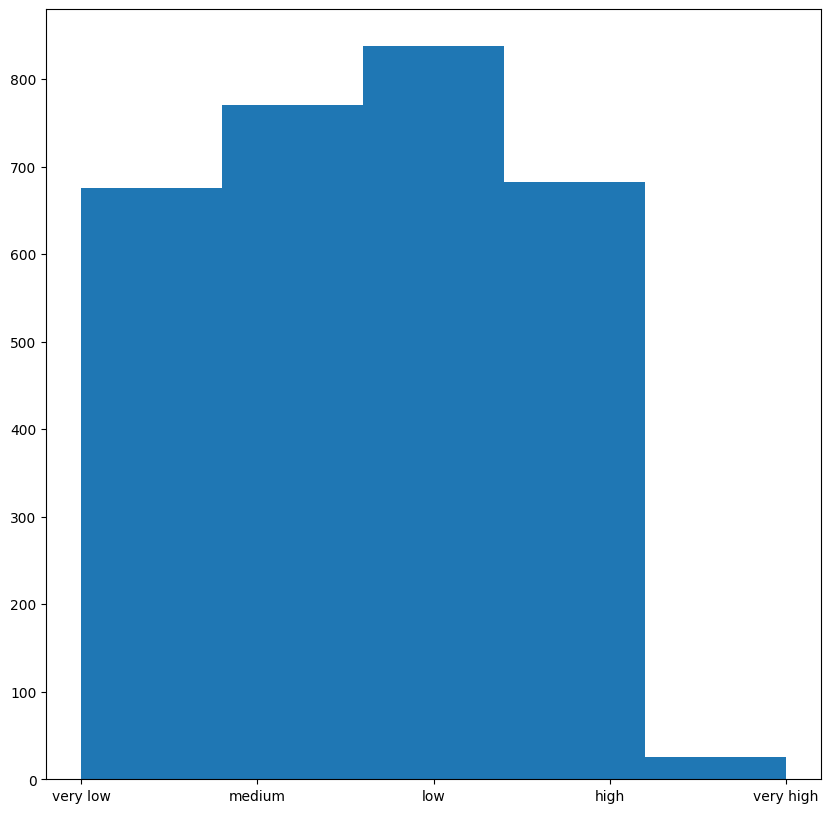

In [104]:
y_pred = cv.predict(X_test)

plt.hist(y_pred, bins=5);

In [105]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.47      0.49      0.48       652
         low       0.39      0.41      0.40       802
      medium       0.37      0.36      0.37       782
   very high       0.08      0.02      0.03       118
    very low       0.59      0.63      0.61       639

    accuracy                           0.45      2993
   macro avg       0.38      0.38      0.38      2993
weighted avg       0.43      0.45      0.44      2993

